# Projeto 1 - Ciência dos Dados

Nome:Lorran Caetano Machado Lopes

Nome: Nívea de Abreu Dantas Lima

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [3]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\lorra\OneDrive\Área de Trabalho\Ciencia dos Dados\P1\TweetsClassifier


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [4]:
filename = 'cocacola.xlsx'

In [5]:
train = pd.read_excel(filename)
train.head(10)



,Treinamento,Relevância
0,@kchorrolooko @cocacola_br essa é a melhor bat...,0
1,@cocacola_br @_evertonalmeida #coquinhagelada ...,1
2,@juliettefreirec @bbb @joaoluizpedrosa @cocaco...,0
3,#nowplaying \n[ nicki minaj - super bass ]\...,1
4,#nowplaying \n[ nick jonas - spaceman ]\nen...,1
5,@reprincesa_ temos uma oferta perfeita pra voc...,1
6,"@jaefson nossa! 🔥 quando o amor invade, é semp...",1
7,"@cocacola_br porra arrasou, so ta o preço do m...",1
8,"@a_mxnds ei, espera um pouco. vamos deixar ess...",1
9,@juliaacc a cara do glamour. arrasaram muito 😎,0


In [6]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(10)


,Teste,Relevância
0,rt @sysa86: @bbb @cocacola_br o bbb21 virou um...,0
1,@cocacola_br coca cola te amo meu refrigerante...,1
2,"@karolinemourab tem vezes que a vontade bate, ...",1
3,@kikiilda sede de coquinha? clica aqui 👉 https...,1
4,@sysa86 @bbb @cocacola_br exatamente e eu amo ...,0
5,#nowplaying \n[ maroon 5 - beautiful mistake...,1
6,@carlabuenoe é pra já! 🥰 caminhão do desconto ...,1
7,"@bbb cineminha, coquinha gelada e amigos = mel...",1
8,@ddeysi2 humm... almocinho top! 😋 mas que tal ...,1
9,@jenifer_alineee que tal uma mudança nos plano...,1


In [7]:
train.Relevância.value_counts(True) #

1    0.554054
0    0.445946
Name: Relevância, dtype: float64

___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

O produto em questão é a Coca-cola, e consideramos como relevantes os tweets que continham propagandas com promoções, marcações das pessoas que falavam tanto bem quanto teciam críticas ao produto. Além disso, consideramos como irrelevanes tweets que marcavam o produto de forma aleatória sem transmitir uma postagem coerente a menção. 

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

Abaixo definimos uma função de limpeza para remover os caracteres: enter, :, ", ', (, ), etc e manter os emojis, além de corrigir os espaçamentos. 

In [8]:
import re 
from nltk.tokenize.casual import TweetTokenizer #importando....


def cleanup(text):
    """
        Função de limpeza
        
    """
    punctuation = '[\[\]@!-_.:?;]' #remoção de pontuação, @ e []
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    text_subbed = re.sub(' +', ' ', text_subbed)
    text_subbed = text_subbed.lower()
    text_subbed = re.sub(r'http\S+', '', text_subbed) #remove links
    t = TweetTokenizer()
    text_subbed = t.tokenize(text_subbed) #remover emojissss
    
    return text_subbed

In [10]:
i = train.Treinamento[0]
tweet_limpo = cleanup(i)

In [54]:
#Percorrendo os tweets para aplicar a função de limpeza, seprarndo em listas de palavras
relevante = []
irrelevante = []

j = 0
for i in train.Treinamento:
    tweetl = cleanup(i)
    if train.Relevância[j] == 1:
        # Guardando as palavras dos tweets relevantes como lista 
        relevante += tweetl
    else:
        # Guardando as palavras dos tweets irrelevantes como lista 
        irrelevante += tweetl
        
    j += 1


Criando um conjunto com todas as palavras dos tweets relevantes e irrelevantes:

In [55]:
# Guardando as palavras relevantes em um pd.Series  
serie_relevante = pd.Series(relevante)
# Guardando as palavras irrelevantes em um pd.Series  
serie_irrelevante = pd.Series(irrelevante)

#### Frequências absolutas

Palavras em um texto são variáveis **qualitativas nominais**, portanto usaremos `value_counts()` para obter a tabela de frequências relativas e absolutas:

In [56]:
# Como tabela_relevante é uma pd.Series, podemos usar value_counts() nessa variável
tabela_relevante = serie_relevante.value_counts()


In [57]:
tabela_irrelevante = serie_irrelevante.value_counts()

#### Frequências relativas

In [58]:
tabela_relevante_relativa = serie_relevante.value_counts(True)

In [59]:
tabela_irrelevante_relativa = serie_irrelevante.value_counts(True)

In [60]:
total = relevante + irrelevante
todas_palavras = pd.Series(total)
todas_palavras



todas_palavras_relativa = todas_palavras.value_counts(True)

## Classificação de um tweet: Relevante ou Irrelevante?

Agora vamos ao problema que queremos resolver.

Precisamos dizer se um dado tweetcé mais provável de ser *Relevante* ou *Irrelevante*.

Ou seja, precisa decidir: 

$\quad \Rightarrow$ Se $P(Relevante|tweet) > P(Irrelevante|tweet)$, então o tweet será classificado como *Relevante*.

$\quad \Rightarrow$ Se $P(Irrelevante|tweet) > P(Relevante|tweet)$, então o tweet será classificado como *Irrelevante*.


<br>

A partir deste ponto, vamos denotar $Relevante$ como $R$ e $Irrelevante$ como $I$ para brevidade.

O **Teorema de Bayes** vai ser particularmente útil neste caso. Lembre-se que:

$\quad P(R|tweet) = \frac{P(tweet|R)P(R)}{P(tweet)}$

e que:

$\quad P(I|tweet) = \frac{P(tweet|I)P(I)}{P(tweet)}$


<br>
Teremos que calcular **TODAS** as probabilidades que se encontram no lado direito das equações acima e com elas calcular $P(R|tweet)$ e $P(I|tweet)$.


Tweet exemplo fictício a classificar:

In [61]:

tw = "amo coquinha gelada"

In [19]:
#Vamos converter primeiro em minúsculas e fazer a limpeza:
tw = cleanup(tw.lower())
tw

['amo', 'coquinha', 'gelada']

### A ingenuidade - Naïve Bayes

Agora vamos à parte ingênua do Naïve Bayes, que consiste em assumir que as palavras são independentes entre si e que sua ordem no tweet não importa. 


Ou seja:

$\quad P(tweet|R) = 
P(odeio|R)\cdot P(batata|R)\cdot P(frita|R)$


<br>

Vamos denotar **Relevante** simplesmente como $R$, para encurtar a fórmula a seguir aplicando o uso do Teorema de Bayes.

Assim, a fórmula completa fica:

$P(R|tweet) = \frac{P(odeio|R).P(batata|R).P(frita|R).P(R)}{P(tweet)}$

<br>

Da mesma forma, denotando **Irrelevante** como $I$, a fórmula completa fica:

$P(I|tweet) = \frac{P(odeio|I).P(batata|I).P(frita|I).P(I)}{P(tweet)}$
<br>

Note que o denominador das duas probabilidade condicionais acima é o mesmo, para fazer a classificação da frase podemos cancelar o cálculo do denominador $P(tweet)$. 

Assim, a **Classificação do tweet** se dará conforme abaixo:

$\quad \Rightarrow$ Se $P(R|tweet) > P(I|tweet)$, então frase será classificada como *Relevante*

$\quad \Rightarrow$ Se $P(R|tweet) < P(I|tweet)$, então frase será classificada como *Irrelevante*

In [20]:
#CALCULANDO OS VALORES DOS PRIORS P(R) E P(I)
total = len(relevante)+len(irrelevante) 
P_R = len(relevante)/total
P_I = len(irrelevante)/total

print(P_R, P_I)

0.7243765316419202 0.2756234683580799


Calculando os termos: 

$\quad P(tweet|R)$

e 

$\quad P(tweet|I)$

<br>

Armazenando o valor de $P(tweet|R)$ e $P(tweet|I)$ nas variáveis `probTweetDadoR` e `probTweetDadoI`.

In [21]:
probTweetDadoR = 1
probTweetDadoI = 1

for i in tw:
    probTweetDadoR *= tabela_relevante_relativa[i]
    probTweetDadoI *= tabela_irrelevante_relativa[i]
    
print(probTweetDadoR, probTweetDadoI)

2.9459888498400543e-08 4.578110960078212e-09


Calculando $P(L|frase)$ e $P(C|frase)$ como indicado acima. 

In [22]:
P_R_dado_T = probTweetDadoR * P_R
P_R_dado_T 

2.134005185302908e-08

In [23]:
P_I_dado_T = probTweetDadoI * P_I
P_I_dado_T 

1.2618348213448957e-09

In [24]:
def classificador(r, i):
    if r > i:
        return("Comparando as probabilidades acima, o tweet é classificada como Relevante " )
    elif i > r:
        return("Comparando as probabilidades acima, o tweet é classificada como Irrelevante ")
    else:
        return("Não é possível dizer, as probabilidades são iguais.")
    
classificador(P_R_dado_T, P_I_dado_T)

'Comparando as probabilidades acima, o tweet é classificada como Relevante '

### Suavização de Laplace: E se a palavra não estiver no conjunto universo? P(palavra|Universo)=0?



Caso apareça uma palavra estranha ou que não esteja na base de dados, precisamos amplificar nosse leque de equações utilizando um recurso matemático conhecido como <b><em>Suavização de Laplace</em></b>, que consiste em basicamente "incluir" a nova palavra no âmbito das probabilidades relativas de uma determinada palavra ser classificada como Relevante ou Irrelevante.

Para realizar tal recurso, devemos analisar quantas vezes a palavra analisada aparece no absolutamente na comapração em questão, seja relevante ou irrelavante, somar uma unidade (que evita o <b>0</b>) no numerador, e somar a quantidade de "possíveis palavras no denominador", isto é a quantidade de palavras únicas pertencentes ao dataset de tweets relevantes ou irrelevantes. Matematicamente teremos:

$$P(palavra1|R) = \frac{F_{AR}+1}{P_{R}+P_p}$$

$$P(palavra1|I) = \frac{F_{AI}+1}{P_{I}+P_p}$$

Onde: 

$ F_{AR}$: Frequência absoluta da palavra na categoria relevante 

$ F_{AI}$: Frequência absoluta da palavra na categoria irrelevante 
    
$P_{R}$: Todas as palavras pertencentes aos tweets rotulados como relevantes
    
$P_{I}$: Todas as palavras pertencentes aos tweets rotulados como irrelevantes

$P_p$: Todas as palavras possíveis na base de dados de treinamento

Considerando isso, temos agora as probabilidades $P(tweet|R)$ e $P(tweet|I)$ adequadas para receber palavras novas em seu universo.

In [62]:
Pr = len(relevante)
Pi = len(irrelevante)
Pp = Pr + Pi


def relevancia (tweet):
    Far = 0
    Fai = 0
    probTweetDadoR = 1
    probTweetDadoI = 1
    for palavra in tweet:
        Far = relevante.count(palavra)
        Fai= irrelevante.count(palavra)
        #print(Far)
        probTweetDadoR *= (Far + 1)/(Pr + Pp) 
        probTweetDadoI *= (Fai + 1)/(Pi + Pp) 
    if probTweetDadoR > probTweetDadoI:
        return 1
    else:
        return 0


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [63]:
classs = []
for i in test["Teste"]:
    i = cleanup(i.lower())
    classs.append(relevancia(i))

classs = pd.Series(classs)
test["Classificador"] = classs

In [28]:
test # a limpeza é feita apenas para classificar. Mantemos o tweet original no DF

,Teste,Relevância,Classificador
0,rt @sysa86: @bbb @cocacola_br o bbb21 virou um...,0,0
1,@cocacola_br coca cola te amo meu refrigerante...,1,0
2,"@karolinemourab tem vezes que a vontade bate, ...",1,1
3,@kikiilda sede de coquinha? clica aqui 👉 https...,1,1
4,@sysa86 @bbb @cocacola_br exatamente e eu amo ...,0,0
...,...,...,...
195,@roinuj_s é muito amor envolvido! 🥰 https://t....,0,1
196,@mazonnys que tal uma oferta para te ajudar a ...,1,1
197,cocacola melhor refri do mundo. 🤤,1,1
198,@augustoscarpin oba! 🔥 mas não se esqueça que ...,1,1


In [64]:
#Porcentagem de verdadeiros positivos (mensagens relevantes e que são classificadas como relevantes)

condicao1 = test.Relevância == 1
condicao2 = test.Classificador == 1
porcentagem_vp = (test.Teste.loc[condicao1 & condicao2].count()/(test.Relevância == 1).sum())*100
porcentagem_vp.round(2)

92.7

In [65]:
#Porcentagem de falsos positivos (mensagens irrelevantes e que são classificadas como relevantes)

condicao3 = test.Relevância == 0
porcentagem_fp = (test.Teste.loc[condicao3 & condicao2].count()/(test.Relevância == 0).sum())*100
porcentagem_fp.round(2)

17.46

In [66]:
#Porcentagem de verdadeiros negativos (mensagens irrelevantes e que são classificadas como irrelevantes)
condicao4 = test.Classificador == 0
porcentagem_vn = (test.Teste.loc[condicao3 & condicao4].count()/(test.Relevância == 0).sum())*100
porcentagem_vn.round(2)

82.54

In [67]:
#Porcentagem de falsos negativos (mensagens relevantes e que são classificadas como irrelevantes)
porcentagem_fn = (test.Teste.loc[condicao1 & condicao4].count()/(test.Relevância == 1).sum())*100
porcentagem_fn

7.2992700729927

In [68]:
pd.crosstab(test.Relevância, test.Classificador, normalize = "index").round(3)*100

Classificador,0,1
Relevância,,
0,82.5,17.5
1,7.3,92.7


In [69]:
pd.crosstab(test.Relevância, test.Classificador, normalize = True).round(3)*100 #em relação ao total

Classificador,0,1
Relevância,,
0,26.0,5.5
1,5.0,63.5


___
### Concluindo

Os percentuais obtidos demonstram que o classificador apresenta um desempenho bom, haja vista que
ele acertou em aproximadamente 89,5% dos casos. Além disso, ele acerta mais quando o tweet analisado é relevante.

Nosso classificador apresenta algumas limitações, tais como não interpretar corretamente sarcasmo e dupla negação. O sarcasmo é compreendido por nós pois ele está ligado a outros aspectos da comunicação humana, como entonação, gesticulação. Falamos algo mas queremos dizer extamente o oposto. E nosso classificador não consegue interpretar sarcasmo pois analisa apenas as palvras dos tweets, sem informações adicionais. Ele utiliza-se apenas de ferramentas matemáticas probabilísticas.

A ferramenta desenvolvida, mesmo apresntando um desempenho muito bom, pode vir a ser melhorada e tornar-se cada vez mais precisa. Para tanto, o financiamento do projeto deve continuar sendo realizado. Com mais financiamento, seria possível, por exemplo, expandir a base de dados de treinamento, o que implicaria em melhora no desempenho do classificador. 
 
O classificador poderia ser utilizado em outros contextos, tais como, por exemplo, no diagnóstico de doenças de um paciente. A base poderia ser a descrição de sintomas e, a classificação, a doença diagnosticada. Isso seria útil para auxiliar os médicos em seus diagnósticos de pacientes.
Outro cenário de possível uso do classificador seria na classificação de textos por área de conhecimento. Por exemplo: um texto que contenha muitas repetições de palavras como "derivada" e "integral" poderia ser classificado como da área de exatas. Já um texto com alta repetição de palavras como "céculas" e "mitocôndrias" poderia ser classificado como da área de biológicas. 

Não podemos usar o próprio classificador para gerar mais amostras de treinamento pois ele se restringe a apenas ferramentas matemáticas de probabilidade, que ignora todo o contexto do frase e tudo mais que está compreendível para nós por questões culturais. Além disso, a classificação manual recebida pelo classificador na base Treinamento está sujeita ao viés de quem a fez. Esse viés seria retransmitido e diminuiria a acurácia do classificador. 

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Um importante passo no aprendizado de máquina é trabalhar com uma boa base de dados
para o treinamento e teste do seu classificador. Entretanto, é razoável pensar que a divisão
de dados utilizada até aqui em nosso Classificador representa uma entre muitas possíveis combinações.
Assim sendo, aqui o objetivo é avaliar como os tweets contidos na base de dados
treinamento podem interferir numa melhor ou não tão boa classificação das mensagens
contidas na base de teste. 
Sendo assim, iremos juntar todos os tweets e criar 100 novas divisões aleatórias.

In [36]:

percentual_acuracia = [] #lista que guardará a acurácia de cada repetição do loop
# novo df com todos tweets
dftest = pd.read_excel(filename, sheet_name = 'Teste')
dftest = dftest.rename(columns={'Teste':'Todos'})
dftrain = pd.read_excel(filename, sheet_name = 'Treinamento')
dftrain = dftrain.rename(columns={'Treinamento':'Todos'})
dfall = pd.concat([dftest,dftrain])


In [37]:
for i in range(100):
    #separando em 2 aleatoriamente, e refazendo todo processo para guardar as acurácias
    #separarando em treinamento e teste
    train2, test2 = train_test_split(dfall, test_size=0.4)
    #separando por relevancia
    relevante2 = train2[train2['Relevância']==1]
    irrelevante2 = train2[train2['Relevância']==0]
    #criando listas com as palavras limpas 
    lista_relev2 = []
    lista_irrelev2 = []
    #limpa os tweets e cria banco de palavras relevantes e irrelevantes
    for tweet in relevante2["Todos"]:
        tweetl = cleanup(tweet)
        lista_relev2 += tweetl    
    for tweet in irrelevante2["Todos"]:
        tweetl = cleanup(tweet)
        lista_irrelev2 += tweetl 
    #Tamanho do universo relevante e irrelevante
    Pr = len(relevante2)
    Pi = len(irrelevante2)
    #Tamanho total
    Pp = Pr + Pi
    #Definindo frequencia absoluta inicial 
    Far = 0
    Fai = 0
    #função que classificará em 0 ou 1, irrelevante ou relevante pela suavização de LaPlace
    def relevancia2 (tweet):
        Far = 0
        Fai = 0
        probTweetDadoR = 1
        probTweetDadoI = 1
        for palavra in tweet:
            Far = lista_relev2.count(palavra)
            Fai= lista_irrelev2.count(palavra)
            probTweetDadoR *= (Far + 1)/(Pr + Pp) 
            probTweetDadoI *= (Fai + 1)/(Pi + Pp) 
        if probTweetDadoR > probTweetDadoI:
            return 1
        else:
            return 0
    #lista que guardará a classificação
    classs2 = []
    #limpa os tweets p/ classificar e classifica
    for i in test2["Todos"]:
        i = cleanup(i.lower())
        classs2.append(relevancia2(i))

    #adicionando a coluna classificação com valores no df test2
    test2["Classificador"] = classs2
    #condicições para filtro e obter acurácia
    condicao1n = test2.Relevância == 1
    condicao2n = test2.Classificador == 1
    condicao3n = test2.Relevância == 0
    condicao4n = test2.Classificador == 0
    porcentagem_vp = (test2.Todos.loc[condicao1n & condicao2n].count()/((test2.Relevância == 0).sum()+(test2.Relevância == 1).sum()))*100
    #Porcentagem de verdadeiros negativos (mensagens irrelevantes e que são classificadas como irrelevantes)
    porcentagem_vn = (test2.Todos.loc[condicao3n & condicao4n].count()/((test2.Relevância == 0).sum() + (test2.Relevância == 1).sum()))*100
    #salvando a acurácia em % na lista
    percentual_acuracia.append(porcentagem_vp+porcentagem_vn)


<ipython-input-37-e2d365b39863>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2["Classificador"] = classs2


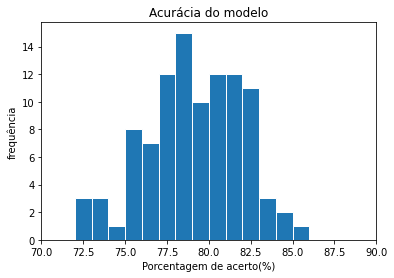

In [50]:
# faixas de AMPLITUDES IGUAIS
faixa1 = np.arange(70,90,1.)
faixa1

# Histograma da variável acurácia em % considerando faixas de AMPLITUDES IGUAIS
plt.hist(percentual_acuracia, bins=faixa1, edgecolor='white')
plt.title('Acurácia do modelo')
plt.ylabel('frequência')
plt.xlabel('Porcentagem de acerto(%)')
plt.xlim(70,90)
plt.show()

In [53]:
percentual_acuracia = pd.Series(percentual_acuracia)
print(f'O mínimo da acurácia foi de {percentual_acuracia.min():.2f} %')
print(f'O máximo da acurácia foi de {percentual_acuracia.max():.2f} %')
print(f'A média da acurácia foi de {percentual_acuracia.mean():.2f} %')

O mínimo da acurácia foi de 72.37 %
O máximo da acurácia foi de 85.53 %
A média da acurácia foi de 79.11 %


Baseando-se no histograma acima, é possível observar uma variação considerável da acurácia para variações das planilhas de teste e treinamento. Logo é possivél concluir que ao tomar apenas um único arranjo das bases, há o risco de tanto chegar numa acurácia mais baixa que a melhor possível quanto de ficar próxima da média. Assim, fica ressaltada a desvantagem de dividir a base só uma única vez, visto que essa divisão tem grande probabilidade de não ser a melhor possível.

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

https://www.datageeks.com.br/naive-bayes/ **Outro contexto de aplicação**